# Experimento Softmax

<a href="https://colab.research.google.com/github/kikaymusic/EscuderoRodriguezSanchez/blob/main/k_brazos/bandido_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación del entorno


In [ ]:
import sys
import os

def setup_workdirectory(
    repo_url="https://github.com/kikaymusic/EscuderoRodriguezSanchez.git",
    branch="dev",
    repo_name="EscuderoRodriguezSanchez",
    directoy_name="k_brazos"
):
    """
    Función para detectar si el código se está ejecutando en Google Colab o en local
    y configurar el entorno de trabajo en consecuencia.
    """
    # Detectamos si estamos en Google Colab
    in_colab = "google.colab" in sys.modules

    if in_colab:
        print("Entorno detectado: Google Colab")

        # Definimos la ruta del repositorio en Colab
        repo_path = f"/content/{repo_name}"

        # Borramos el repositorio si ya existe para evitar conflictos
        if os.path.exists(repo_path):
            os.system(f"rm -rf {repo_path}")

        # Clonamos la rama especificada del repositorio
        os.system(f"git clone -b {branch} --single-branch {repo_url}")

        # Cambiamos al directorio del repositorio
        os.system(f"%cd {repo_path}")

        # Añadimos el directorio especificado al path
        sys.path.append(f'/content/{repo_name}/{directoy_name}')

    else:
        print("Entorno detectado: Local")

        # Añadir el directorio especificado al path de Python
        notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
        k_brazos_dir = notebook_dir if directoy_name in notebook_dir else os.path.join(notebook_dir, directoy_name)
        if k_brazos_dir not in sys.path:
            sys.path.insert(0, k_brazos_dir)


setup_workdirectory()

Working directory: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos
Added to path: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos


In [2]:
#@title Importamos todas las clases y funciones
from src.algorithms.softmax import Softmax

import numpy as np
from typing import List

from src.arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics

from src.run_experiment import run_experiment

from src.utils import SEMILLA, K, STEPS, RUNS

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Hemos definido un marco experimental común para todas las familias de algoritmos, en el cual tendremos un bandido de 10 brazos, que se ejecutará durante 2000 pasos, y repetiremos el experimento 500 veces. Los resultados obtenidos serán el promedio de las recompensas obtenidas en cada paso para cada una de las ejecuciones.

Para el caso del algoritmo Softmax, tenemos el parámetro de temperatura tau, que controla el grado de exploración y explotación. Para nuestros experimentos, probaremos el algoritmo Softmax con 3 valores para este parámetro, que serán 0.1, 1 y 5. Con los valores más bajos, el algoritmo tendrá una tendencia a la explotación, mientras que valores más altos tendrán una mayor tendencia a la exploración. El valor de 1 es un valor equilibrado entre explotación y exploración.

In [3]:
# Parámetros del experimento
np.random.seed(SEMILLA)  # Fijar la semilla para reproducibilidad

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [
    Softmax(k=K, tau=0.1),   # Casi Greedy (Explotación)
    Softmax(k=K, tau=1.0),   # Balanceado
    Softmax(k=K, tau=5.0),   # Muy aleatorio (Exploración)
]

## Ejecución del experimento con distribución Normal

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 2000 pasos cada una. Se contrastan 3 algoritmos Softmax para valores tau: 0.1, 1, y 5.

In [4]:
# Creación del bandit
bandido = Bandit(arms=ArmNormal.generate_arms(K)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_normal, optimal_selections_normal, arm_stats_normal = run_experiment(bandido, algorithms, STEPS, RUNS)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados distribución Normal

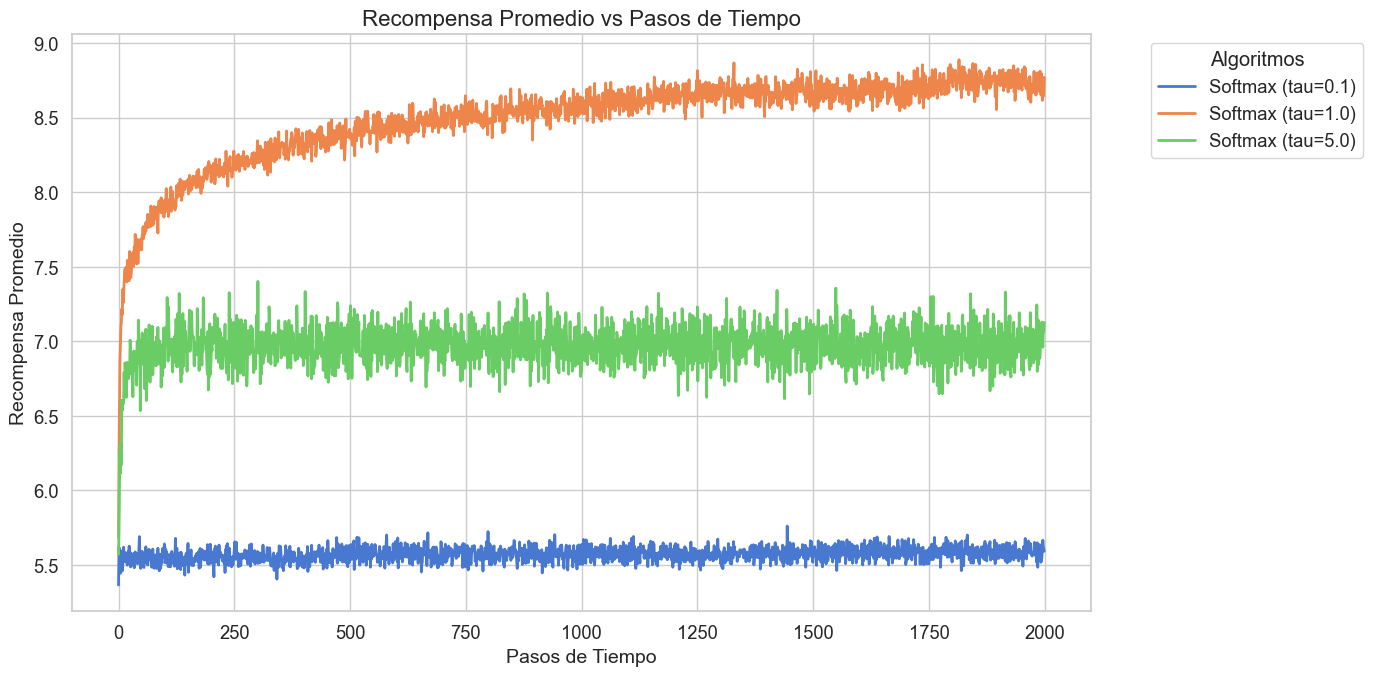

In [5]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_normal, algorithms)

### Análisis del Algoritmo Softmax (Distribución Normal)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 2000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y generando resultados mediocres que no mejoran a lo largo del tiempo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, podemos ver que el algoritmo va mejorando conforme el paso del tiempo, llegando al paso 750 a una recompensa de 8.5 y ya presentando una mejora más lenta a lo largo del tiempo. Aún así, seguimos un poco lejos de 9,56 que era el valor de recompensa esperado.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso, podemos ver que al principio el algoritmo va mejorando, pero llega un punto en el que la exploración excesiva hace que el algoritmo no explote los mejores brazos y se quede generando unos resultados malos.

---

In [6]:
print(f"optimal selections: {optimal_selections_normal}")

optimal selections: [[0.09  0.09  0.09  ... 0.09  0.09  0.09 ]
 [0.09  0.108 0.116 ... 0.454 0.454 0.47 ]
 [0.088 0.098 0.114 ... 0.214 0.224 0.19 ]]


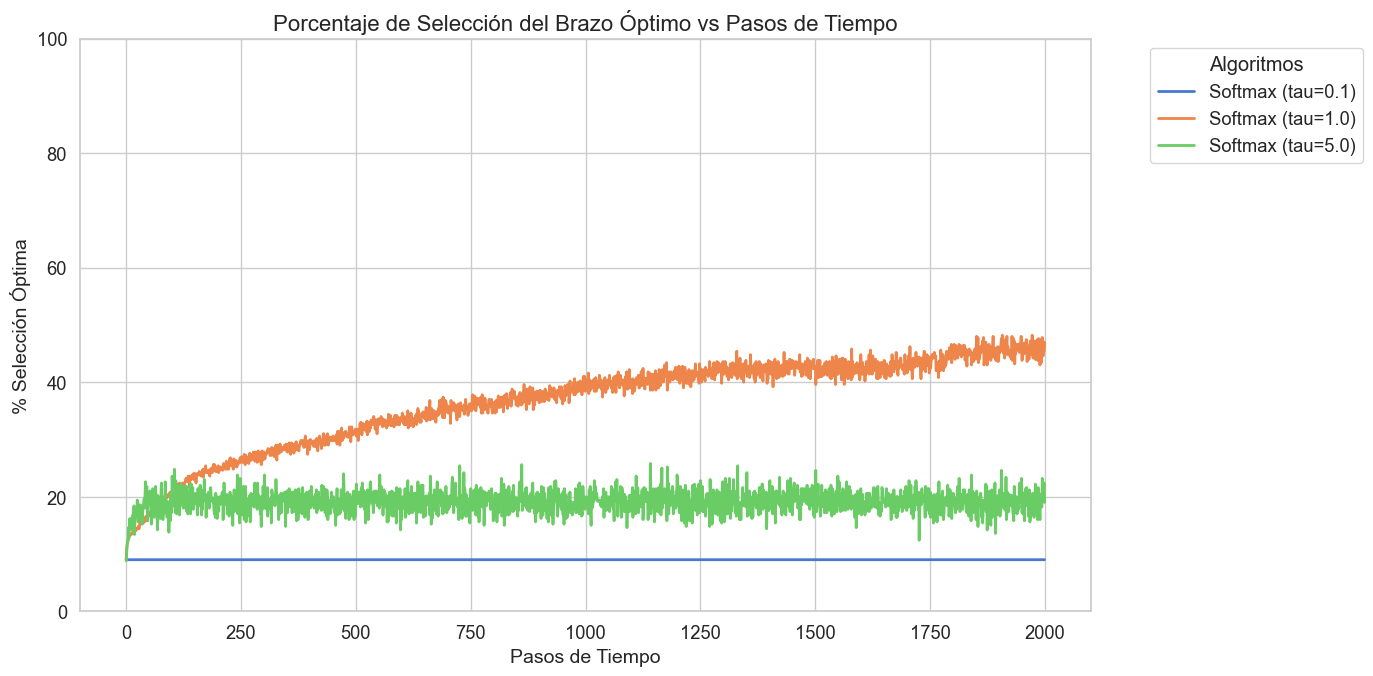

In [7]:
plot_optimal_selections(STEPS, optimal_selections_normal, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y solo llegamos a un 10% de selección del brazo óptimo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este paso podemos ver una mejora a lo largo del tiempo, pero aún así solo consigue alcanzar un 45% aproximadamente en el paso 2000.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que se quede en un 20% de selección del brazo óptimo.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

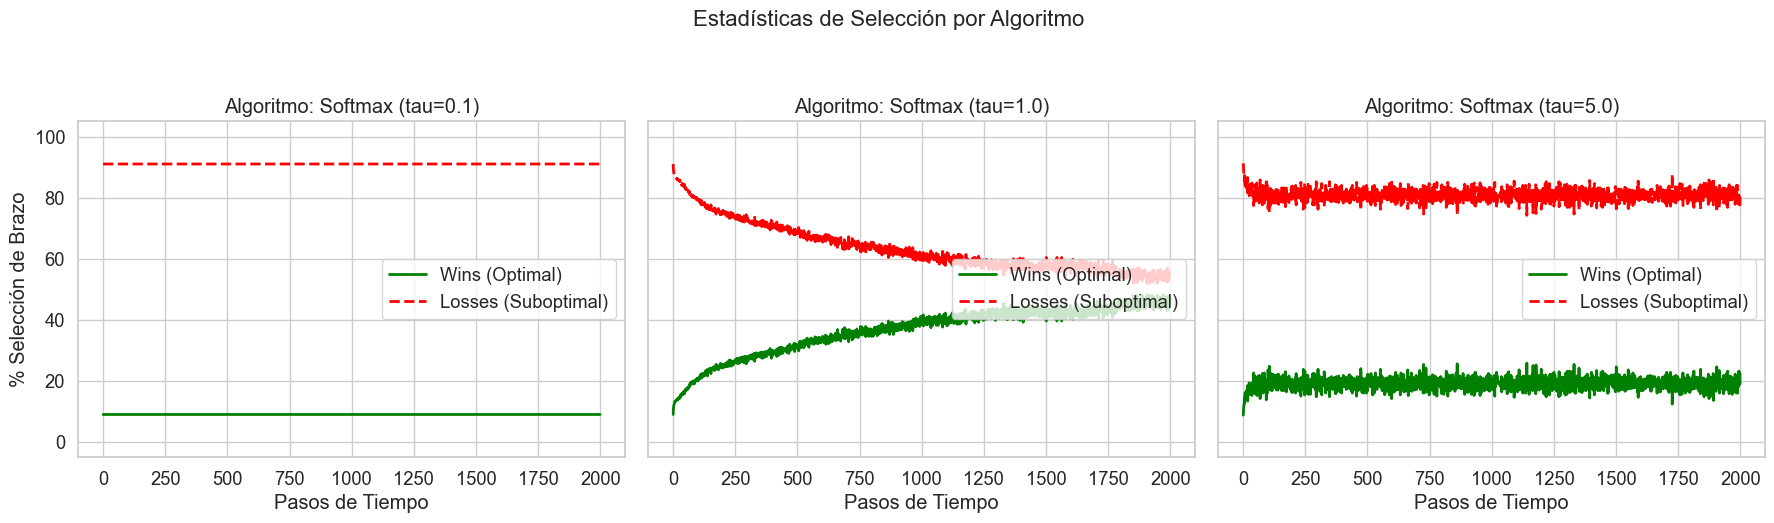

In [8]:
plot_arm_statistics(arm_stats_normal, algorithms)

En la gráfica anterior representamos los diferentes parámetros de los algoritmos Softmax en el experimento sobre distribución normal. Se puede observar que considerando `wins` como la elección del brazo correcto y `losses` como la elección del brazo incorrecto, el algoritmo con `tau=1` es el que más veces selecciona el brazo óptimo, teniendo además un crecimiento constante, mientras que el algoritmo con `tau=0.1` es el que menos veces lo hace, al igual que con las recompensas obtenidas. Por último, el algoritmo `tau=5` genera unos resultados superiores al algoritmo con `tau=0.1`, pero se sigue manteniendo en resultados malos y sin mejora.

Por otro lado, dado que *losses* es no aceptar el brazo que genera recompensa, podríamos decir que obtener los resultados de losses es lo mismo que hacer 1-wins, por lo que consideramos que podríamos eliminar su cálculo de la función run_experiment para evitar el coste del cálculo, aunque lo mantendremos para justificar esta afirmación.



---

## Ejecución del experimento con distribución Binomial

En este experimento al igual que el anterior usamos 10 brazos, para mantener el mismo experimento que para el caso de distribución normal, pero utilizando una distribución binomial. Se realizan 500 ejecuciones de 2000 pasos cada una. Al igual que en el experimento anterior se contrastan 3 algoritmos Softmax para valores tau: 0.1, 1, y 5.

In [9]:
# Creación del bandit
bandido = Bandit(arms=ArmBinomial.generate_arms(K)) # Generar un bandido con k brazos de distribución binomial
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_binomial, optimal_selections_binomial, arm_stats_binomial = run_experiment(bandido, algorithms, STEPS, RUNS)

Bandit with 10 arms: ArmBinomial(n=10, p=0.19), ArmBinomial(n=10, p=0.06), ArmBinomial(n=10, p=0.80), ArmBinomial(n=10, p=0.89), ArmBinomial(n=10, p=0.60), ArmBinomial(n=10, p=0.49), ArmBinomial(n=10, p=0.42), ArmBinomial(n=10, p=0.55), ArmBinomial(n=10, p=0.42), ArmBinomial(n=10, p=0.85)
Optimal arm: 4 with expected reward=8.88772641897212


### Visualización de los resultados del experimento Binomial

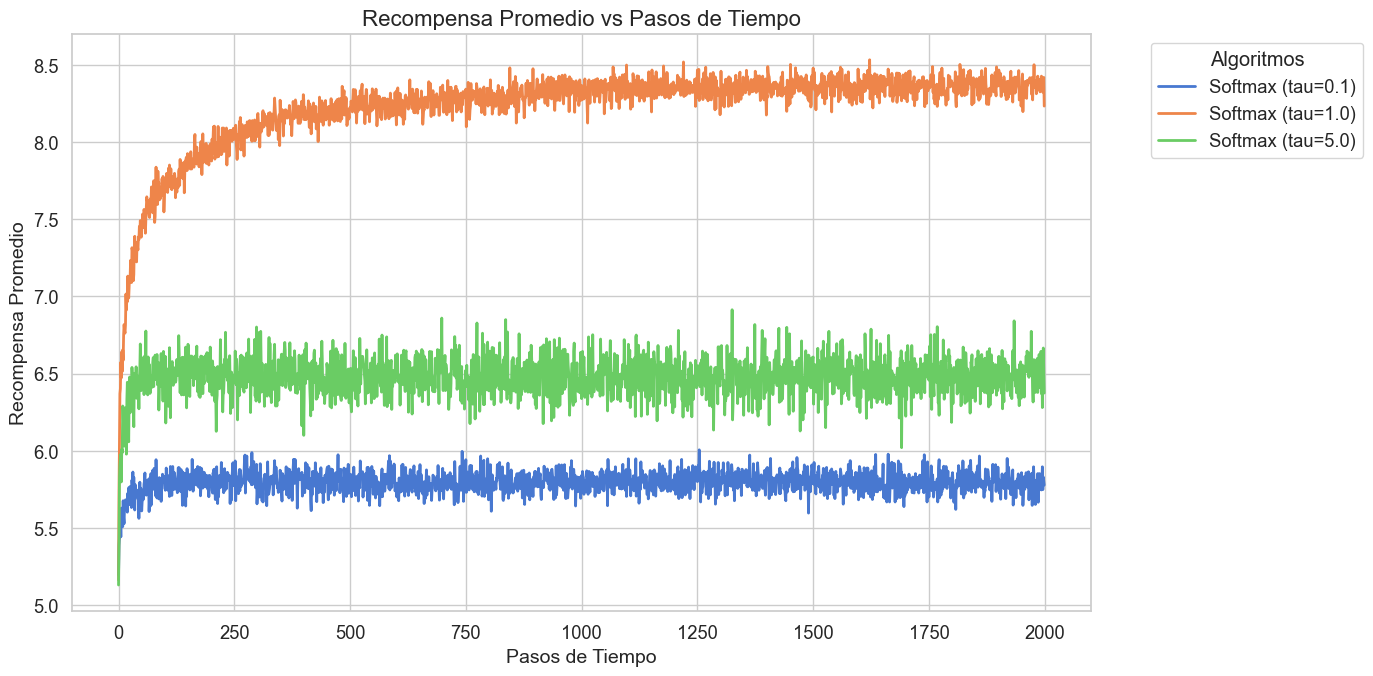

In [10]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_binomial, algorithms)

### Análisis del Algoritmo Softmax (Distribución Binomial)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 2000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que la poca exploración del algoritmo hace que se consiga un poco de mejora a lo largo del tiempo, pero aún así genera los peores resultados de los 3 algoritmos.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, podemos ver una mejora en el tiempo hasta llegar más o menos al paso 500, en el cual el algoritmo mejora lentamente y se queda proximo a un valor de 8.4, que se aproxima a nuestro valor estimado de 8,88.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. Aquí podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que no se explote un brazo que genere mejores resultados y se queda generando un 6.5 de recompensa aproximadamente.

---

In [11]:
print(f"optimal selections: {optimal_selections_binomial}")

optimal selections: [[0.104 0.106 0.108 ... 0.112 0.112 0.112]
 [0.094 0.128 0.15  ... 0.45  0.444 0.432]
 [0.082 0.106 0.12  ... 0.186 0.186 0.152]]


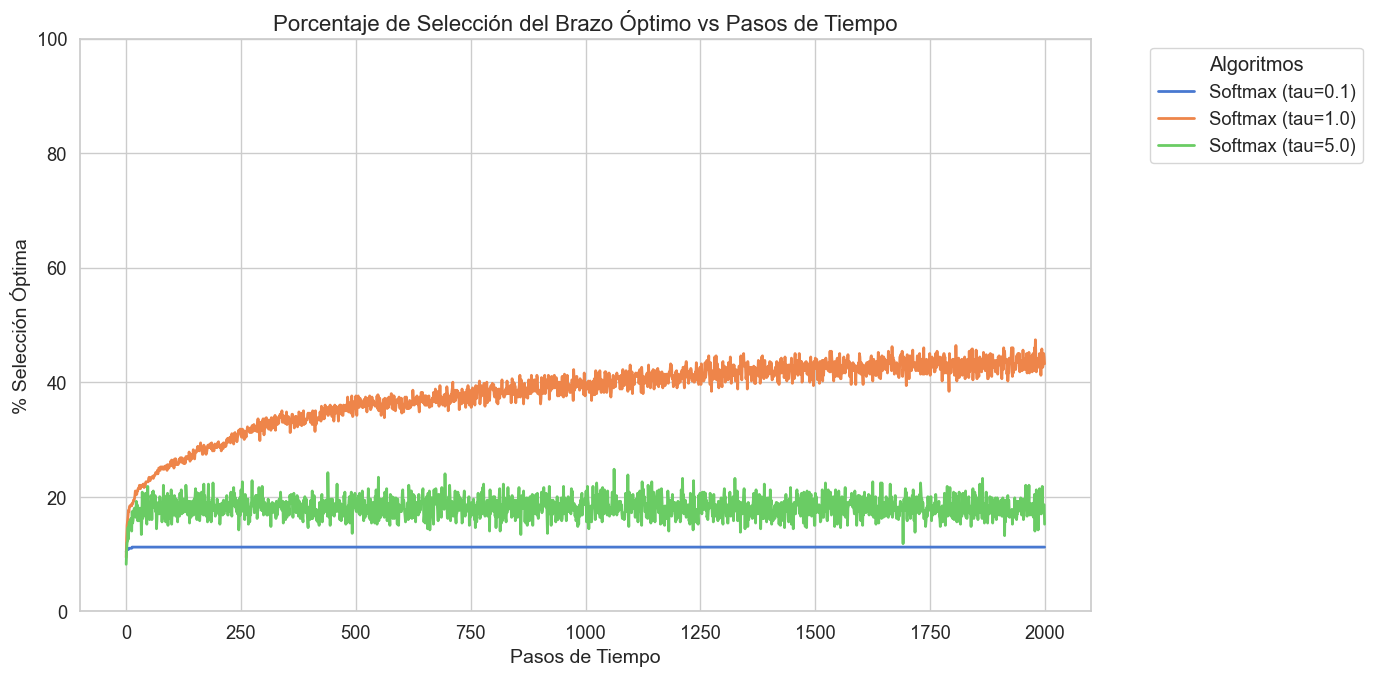

In [12]:
plot_optimal_selections(STEPS, optimal_selections_binomial, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Podemos ver que al aplicar poca exploración, el algoritmo se queda encerrado en un brazo suboptimo y solo llegamos a un 10% de selección del brazo óptimo aproximadamente.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este paso podemos ver una mejora a lo largo del tiempo, pero aún así solo consigue superar por poco el 40% a partir del paso 1000. Aún así, aunque no ha conseguido alcanzar la recompensa esperada, en este caso los resultados obtenidos por los brazos elegidos no han sido tan malos como refleja esta gráfica.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver una pequeña mejora al principio, pero la exploración excesiva hace que se quede en un 20% de selección del brazo óptimo.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

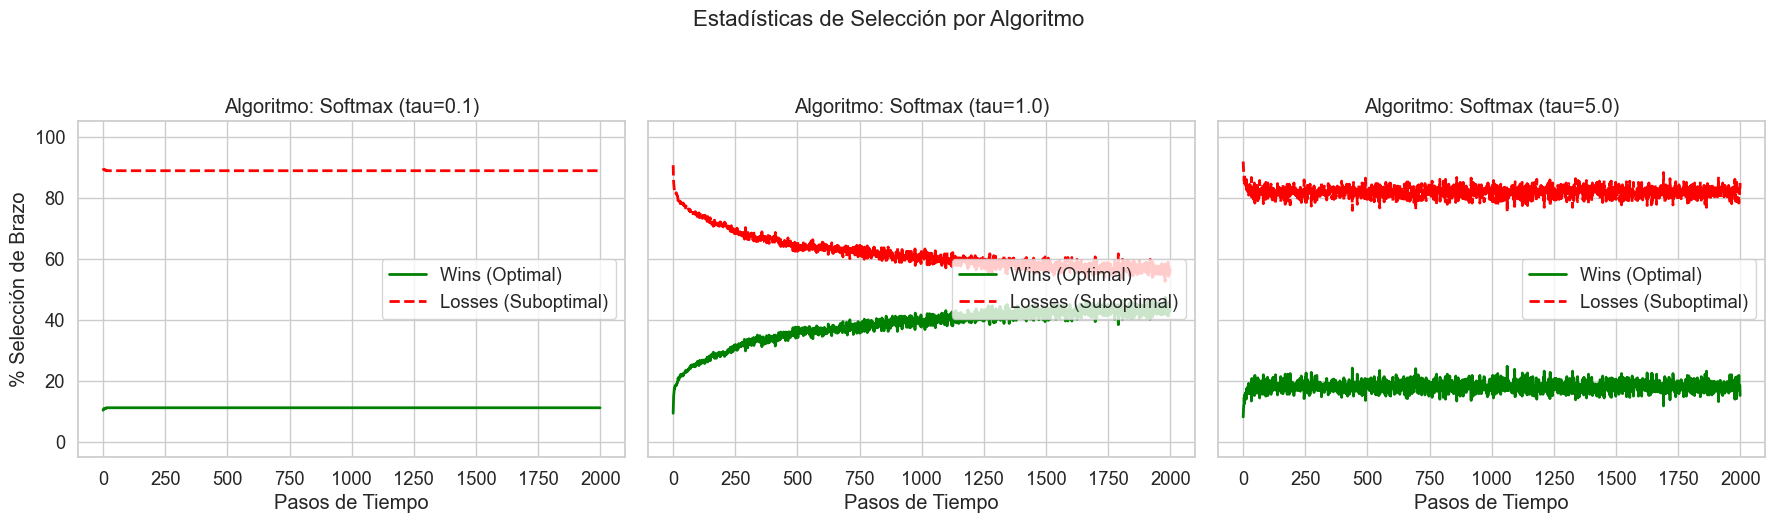

In [13]:
plot_arm_statistics(arm_stats_binomial, algorithms)

Al igual que en el experimento anterior, los valores de wins y losses son prácticamente los mismos y coinciden (evidentemente) con la gráfica de porcentaje de seleccion del brazo óptimo.

---

## Ejecución del experimento con distribución Bernoulli

Al igual que para el resto de distribuciones se realiza el experimento usando 10 brazos, pero para este escenario utilizamos una distribución discreta con valores entre 0 y 1. Se realizan 500 ejecuciones de 2000 pasos cada una. Al igual que en el experimento anterior se contrastan 3 algoritmos Softmax para valores tau: 0.1, 1, y 5.

In [14]:
# Creación del bandit
bandido = Bandit(arms=ArmBernoulli.generate_arms(K)) # Generar un bandido con k brazos de distribución Bernoulli
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_bernoulli, optimal_selections_bernoulli, arm_stats_bernoulli = run_experiment(bandido, algorithms, STEPS, RUNS)

Bandit with 10 arms: ArmBernoulli(p=0.32), ArmBernoulli(p=0.98), ArmBernoulli(p=0.10), ArmBernoulli(p=0.53), ArmBernoulli(p=0.90), ArmBernoulli(p=0.06), ArmBernoulli(p=0.63), ArmBernoulli(p=0.89), ArmBernoulli(p=0.15), ArmBernoulli(p=0.46)
Optimal arm: 2 with expected reward=0.9843707431128161


### Visualización de los resultados del experimento Bernoulli

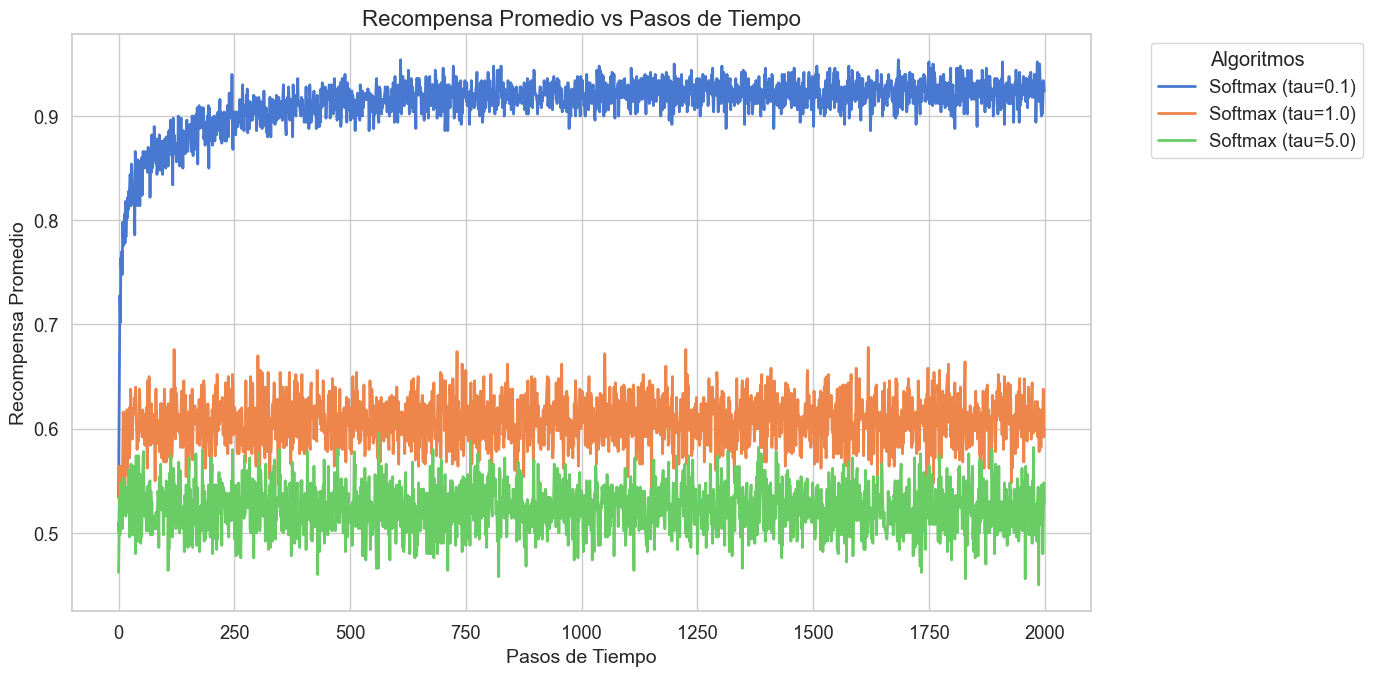

In [15]:
# Graficar los resultados
plot_average_rewards(STEPS, rewards_bernoulli, algorithms)

### Análisis del Algoritmo Softmax (Distribución Bernoulli)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 2000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. En este caso, a pesar de la poca exploración, si podemos ver como el algoritmo pega una mejora al principio y consigue llegar a recompensas de 0.95, por lo que estamos cerca del 0.98 de recompensa esperada.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso, si podemos ver que hay una mejora al principio pero debido a la mayor exploración se queda en un valor aproximado de 0.6 en vez de explotar brazos con mejores recompensas.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver lo mismo que en el algoritmo anterior, pero al tener una mayor exploración, los resultados son incluso peores, quedandonos sobre un 0.55.

---

In [16]:
print(f"optimal selections: {optimal_selections_bernoulli}")

optimal selections: [[0.12  0.17  0.19  ... 0.43  0.426 0.422]
 [0.09  0.1   0.102 ... 0.178 0.124 0.15 ]
 [0.11  0.108 0.12  ... 0.13  0.104 0.124]]


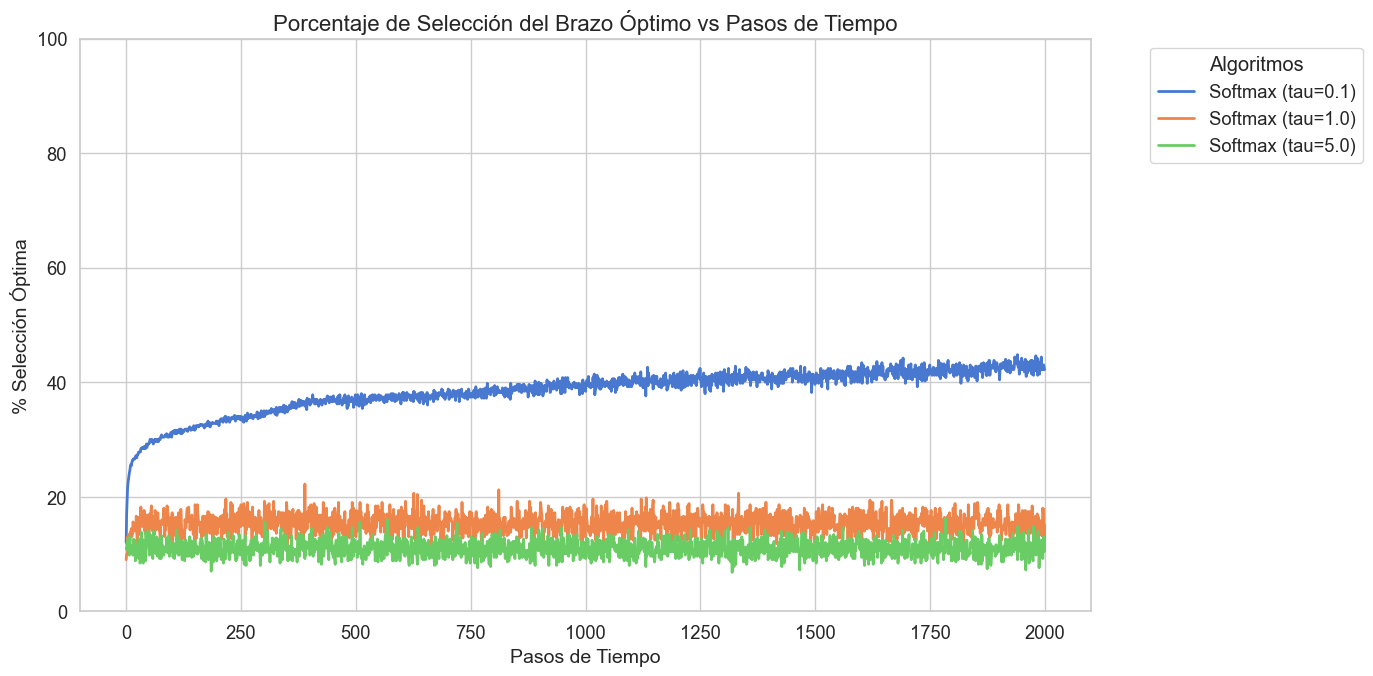

In [17]:
plot_optimal_selections(STEPS, optimal_selections_bernoulli, algorithms)

### Análisis detallado de la selección óptima


El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 2000 pasos, comparando diferentes valores del parámetro (tau).

* **Azul (tau=0.1):** Este es el valor de tau más centrado en la explotación. Aún así, podemos ver una mejora a lo largo del tiempo, hasta llegar a un 40% de selección del brazo óptimo.

* **Naranja (tau=1):** Este es el valor de tau más equilibrado en cuanto a exploración y explotación. En este caso podemos ver que la exploración hace que no se consiga encontrar un brazo con buenos resultados, quedandonos por debajo de un 15% de selección del brazo óptimo.

* **Verde (tau=5):** Este es el valor de tau más centrado en la exploración. En este caso podemos ver el mismo problema que en el algoritmo anterior, pero al tener mayor exploración los resultados son incluso peores, quedandonos en un 10%.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

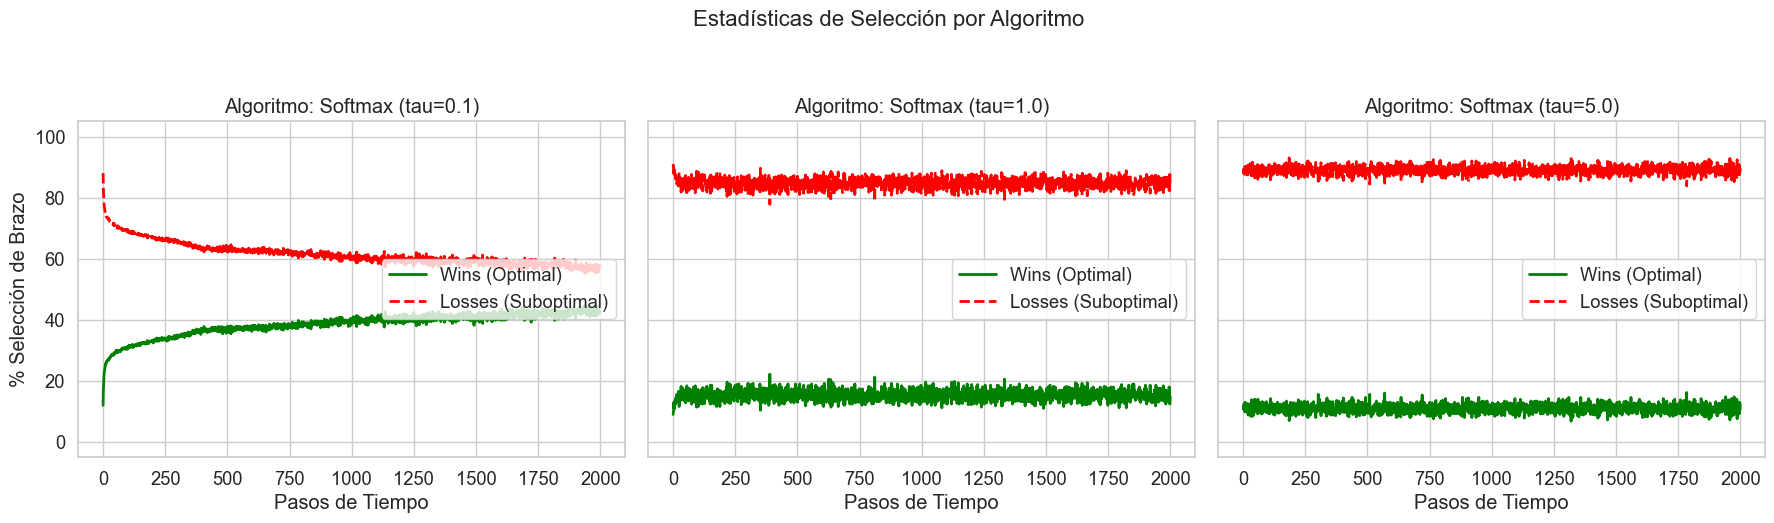

In [18]:
plot_arm_statistics(arm_stats_bernoulli, algorithms)

En este caso,  el algoritmo con `tau=0.1` es el que más veces selecciona el brazo óptimo, teniendo una subida importante en los primeros 500 pasos y teniendo a partir de aquí un ligero crecimiento constante, mientras que los algoritmos con `tau=1` y `tau=5` generan resultados malos que no mejoran a lo largo del tiempo.

---

## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo Softmax, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **Softmax** equilibra la exploración y la explotación con el parámetro tau:
* **Azul (c=0.1):** Excepto para el caso de la distribución de Bernoulli, podemos ver que tan poca exploración hace que el algoritmo se atasque en un brazo que genera malas recompensas y no consigue mejorar a lo largo del tiempo.
* **Naranja (c=1):** Para el caso de la distribución normal y binomial, podemos ver que la exploración extra con respecto al primer algoritmo hace que se consiga una mejora bastante buena en las recompensas obtenidas al avanzar el tiempo. Para el caso de la distribución de Bernoulli, podemos ver que la exploración hace que el algoritmo genere unos resultados bastante malos.
* **Verde (c=5):** En este caso, para las 3 distribuciones, podemos ver que la exploración es escesiva y siempre conseguimos peores resultados que con el segundo algoritmo, que consigue un mejor equilibrio entre exploración y explotación.

#### **2. Convergencia de los algoritmos**
Los algoritmos con un valor de tau más extremo (0,1 y 5) hacen que el algoritmo converga muy rápido, uno por que encuentra un brazo y se queda atascado en el y el otro por que prueba muchos brazos sin quedarse explotando uno. Un valor de tau más equilibrado, como 1, hace que el algoritmo tarde más en converger pero consigue encontrar mejores brazos y conseguir en general mejores recompensas.

#### **3. Gráficas más relevantes**
A lo largo del estudio de la familia de algoritmos, hemos utilizado tres gráficas diferentes: recompensas obtenidas, porcentaje de selección de brazo óptimo y comparación de ganancia vs perdida. En estás tres gráficas hemos calculado el promedio de todas las ejecuciones y hemos mostrado la evolución a lo largo del paso del tiempo. De estás gráficas, la más importante es la de recompensas obtenidas, ya que las otras dos gráficas no reflejan de forma correcta si el algoritmo ha generado buenos resultados. Esto es así ya que un porcentaje bajo de selección de brazo óptimo no implica que las recompensas obtenidas sean bajas, simplemente que no se ha escogido el mejor de los brazos. La gráfica de ganancia vs perdida representa los mismos resultados que la de selección de brazo óptimo, por lo que se aplica el mismo motivo. Esto podemos verlo por ejemplo en la distribución normal, ya que aunque la gráfica naranja obtenia recompensas de 8.75 aproximadamente, siendo 9.56 la recompensa esperada, en la gráfica de selección de brazo óptimo solo alcanza un 45%.

#### **4. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **tau=1** nos permite encontrar brazos que generen buenas recompensas y aún así explotar esos brazos lo suficiente como para mantener buenos resultados.
- **Una excesiva explotación (tau=0.1)** lleva a un desempeño deficiente, ya que se queda atascado en un brazo y no prueba lo suficiente para encontrar brazos mejores.
- **Una excesiva exploración (tau=5)** también lleva a un desempeño deficiente, ya que el agente puede quedarse probando brazos continuamente en vez de centrarse en el que genere buenos resultados.

En conclusión, **los gráficos muestran como un nivel equilibrado de exploración y explotación permite al algoritmo encontrar brazos que son buenos y explotarlos a lo largo del tiempo**.